In [1]:
############ imports ###############
import xarray as xr
import numpy as np
import pandas as pd
from eofs.xarray import Eof

import sys
import os

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
from numpy.random import normal
from scipy.stats import norm

In [4]:
import seaborn as sns

In [5]:
from sklearn.utils import resample

In [6]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.path as mpath
from matplotlib.colorbar import Colorbar

import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)


In [7]:
import scipy

In [8]:
import matplotlib as mpl
mpl.rcParams['mpl_toolkits.legacy_colorbar'] = False

/tmp/ipykernel_1785750/466364334.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.legacy_colorbar rcparam was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  mpl.rcParams['mpl_toolkits.legacy_colorbar'] = False


# Seasonal pattern

## season data

In [9]:
season_data = xr.open_dataset('/work/mh0033/from_Mistral/mh0033/m300883/task1/Hist_obs/obs/Season/pre-processed/detrend.nc')

In [10]:
season_data

<xarray.Dataset>
Dimensions:    (time: 42, bnds: 2, lon: 70, lat: 32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1981-01-01 ... 2021-01-01
  * lon        (lon) float64 -90.0 -88.12 -86.25 -84.38 ... 35.62 37.5 39.38
  * lat        (lat) float64 79.27 77.41 75.54 73.68 ... 27.05 25.18 23.32 21.45
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    var151     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Feb 22 15:13:01 2022: cdo -detrend djf.nc detrend.nc\nT...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [11]:
season_data = season_data.var151/100.0

## daily data

In [ ]:
daily_data = xr.open_dataset('/work/mh0033/m300883/task1/Hist_obs/obs/Daily/ano.nc')

In [ ]:
daily_data

In [14]:
daily_data['time'] = pd.to_datetime(daily_data['time'],format="%Y%m%d")

In [15]:
daily_data = daily_data.var151/100.0

## weights

In [13]:
coslat = np.cos(np.deg2rad(season_data.lat)).clip(0., 1.)
wgts = np.sqrt(coslat.values)[..., np.newaxis]

In [14]:
wgts

array([[0.43147595],
       [0.46695069],
       [0.49968601],
       [0.53015706],
       [0.55870416],
       [0.58558032],
       [0.61097921],
       [0.63505261],
       [0.6579218 ],
       [0.67968521],
       [0.70042387],
       [0.7202052 ],
       [0.73908591],
       [0.75711407],
       [0.77433076],
       [0.7907713 ],
       [0.80646624],
       [0.82144214],
       [0.8357222 ],
       [0.84932674],
       [0.86227365],
       [0.8745787 ],
       [0.88625585],
       [0.89731746],
       [0.90777452],
       [0.91763679],
       [0.92691297],
       [0.9356108 ],
       [0.94373717],
       [0.95129822],
       [0.9582994 ],
       [0.96474557]])

# Do EOF and Projection

In [15]:
# function to calculate coefficent to change the sign of the data    
def coefcal(eof):
    data = eof
    # NAO
    coef_NAO = data.sel(lat = slice(90,60),lon = slice(-70,-10),mode = 'NAO').mean(dim = ['lat','lon'])<0
    coef_NAO = (2*coef_NAO-1)  # to make 1 to 1 , 0 to -1

    # EA
    coef_EA = data.sel(lat = slice(65,45),lon = slice(-40,40),mode = 'EA').mean(dim = ['lat','lon'])<0
    coef_EA = (2*coef_EA-1)

    return xr.concat([coef_NAO,coef_EA],dim = 'mode')

In [16]:
def standardizex(data):
    time_mean = data.mean(dim = 'time')
    time_std = data.std(dim = 'time')
    return (data-time_mean)/time_std

In [17]:
solver = Eof(season_data,weights = wgts,center=True)

In [18]:
eofs = solver.eofs(neofs =2)

In [19]:
eofs

<xarray.DataArray 'eofs' (mode: 2, lat: 32, lon: 70)>
array([[[-1.1939181e-02, -1.1858105e-02, -1.1744756e-02, ...,
         -2.5835356e-02, -2.5736453e-02, -2.5604069e-02],
        [-1.1386443e-02, -1.1496721e-02, -1.1804952e-02, ...,
         -2.9368360e-02, -2.9169764e-02, -2.8926009e-02],
        [-1.1821556e-02, -1.2153292e-02, -1.2423120e-02, ...,
         -3.2483254e-02, -3.2162525e-02, -3.1791743e-02],
        ...,
        [ 3.1714155e-03,  3.1638972e-03,  3.1571558e-03, ...,
          6.5012686e-03,  5.5413819e-03,  4.7239377e-03],
        [ 3.0847760e-03,  2.9929718e-03,  2.8711602e-03, ...,
          6.3160886e-03,  5.5728098e-03,  4.6135182e-03],
        [ 3.0724793e-03,  2.9123302e-03,  2.7134968e-03, ...,
          5.8970670e-03,  5.4069730e-03,  4.5533874e-03]],

       [[ 5.9670018e-04,  8.2169683e-04,  8.6339691e-04, ...,
          8.1423093e-03,  8.0741616e-03,  8.0001997e-03],
        [ 8.6211599e-04,  6.1531563e-04,  2.8147045e-04, ...,
          7.4583949e-03,  7.3514576e-03,  7.2249714e-03],
        [ 3.2352889e-04,  2.3236912e-04,  8.0821359e-05, ...,
          5.5406797e-03,  5.5023865e-03,  5.4307533e-03],
        ...,
        [-2.5203694e-03, -2.6728008e-03, -2.9481838e-03, ...,
          2.0414887e-03,  1.9269880e-03,  1.9590119e-03],
        [-2.9579648e-03, -2.9849580e-03, -3.0272806e-03, ...,
          2.2340831e-03,  1.8313741e-03,  1.7322666e-03],
        [-3.0109638e-03, -2.9533349e-03, -2.9427267e-03, ...,
          2.7495481e-03,  1.8684804e-03,  1.5419441e-03]]], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1
  * lat      (lat) float64 79.27 77.41 75.54 73.68 ... 27.05 25.18 23.32 21.45
  * lon      (lon) float64 -90.0 -88.12 -86.25 -84.38 ... 33.75 35.62 37.5 39.38
Attributes:
    long_name:  empirical_orthogonal_functions

In [20]:
eofs['mode'] = ['NAO','EA']

In [21]:
pcs = solver.pcs(npcs = 2)

In [22]:
pcs['mode']= ['NAO','EA']

In [23]:
    eof_dw = eofs/wgts
    
    # standarize
    std_pc = pcs.std(dim = 'time') #(mode)
    eof_stded = eof_dw*std_pc

In [24]:
coef = coefcal(eofs)

In [25]:
eof_stded = eof_stded*coef

In [26]:
pcs_stded = standardizex(pcs)

In [27]:
pcs_stded=pcs_stded*coef

In [31]:
daily_index = solver.projectField(daily_data,neofs = 2, weighted=True)

In [32]:
daily_index

<xarray.DataArray 'pseudo_pcs' (time: 3780, mode: 2)>
array([[-177.6669  , -175.86281 ],
       [-170.28334 , -208.75464 ],
       [-130.01729 , -156.85748 ],
       ...,
       [ -46.81733 ,  -58.878872],
       [ -88.78824 ,  -88.79784 ],
       [ -96.58675 , -132.76736 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * mode     (mode) int64 0 1
Attributes:
    long_name:  var151_pseudo_pcs

In [33]:
daily_index['mode'] = ['NAO','EA']

In [34]:
daily_index_stded = standardizex(daily_index)

In [35]:
daily_index_stded

<xarray.DataArray 'pseudo_pcs' (time: 3780, mode: 2)>
array([[-1.0988866 , -1.2277212 ],
       [-1.0532186 , -1.4573435 ],
       [-0.80416924, -1.0950426 ],
       ...,
       [-0.28956962, -0.4110411 ],
       [-0.54916364, -0.6199093 ],
       [-0.59739816, -0.92686635]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * mode     (mode) <U3 'NAO' 'EA'

In [36]:
daily_index_stded = daily_index_stded*coef

In [31]:
fra = solver.varianceFraction(neigs = 2)

In [32]:
fra['mode'] = ['NAO','EA']

# visu

In [46]:
def axbuild(ax):
    
    theta = np.linspace(0,2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()
    gl=ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False)
    gl.xformatter = LongitudeFormatter(direction_label=False)
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))

    gl.ylocator = mticker.FixedLocator([20,40,60])
    gl.yformatter = LatitudeFormatter()

    ax.set_extent([-180,180,20,90],crs = ccrs.PlateCarree())
    ax.get_extent(crs = ccrs.PlateCarree())

In [47]:
EOFs_show = eof_stded

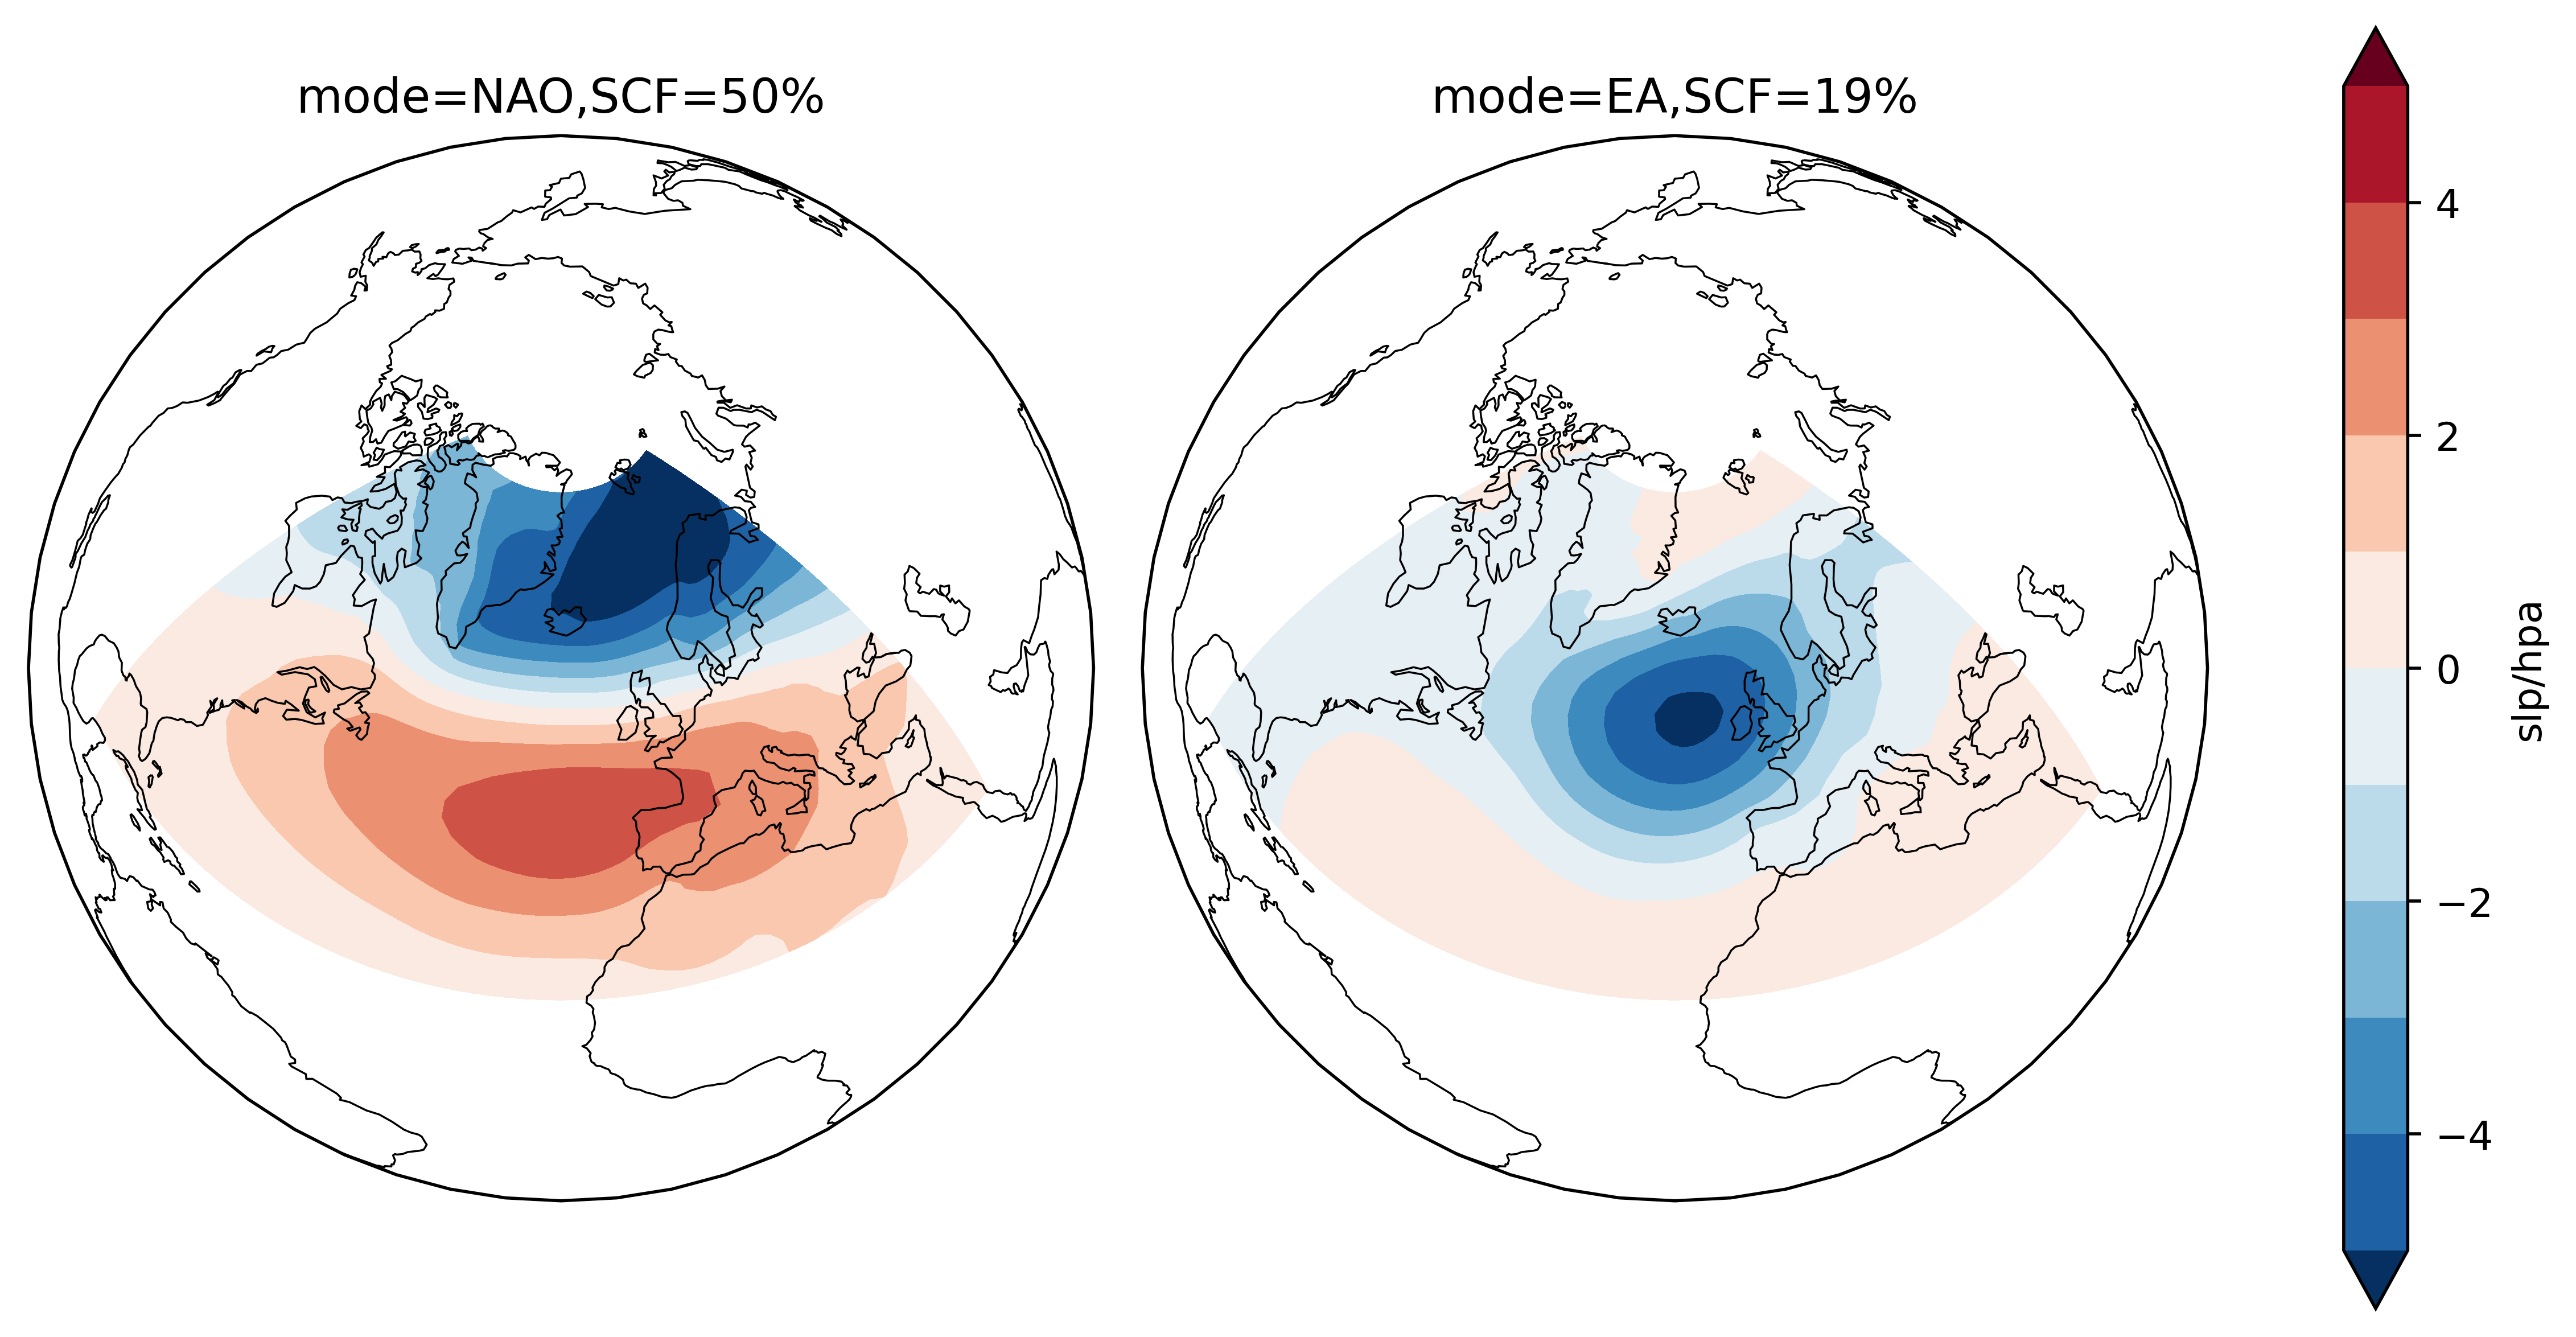

In [108]:
EOFmaps = EOFs_show.plot.contourf('lon','lat',col = 'mode',
                                      levels = np.arange(-5,5.1,1.0),
                                      extend = 'both',
                                      subplot_kws=dict(projection = proj
                                                     )
                                      ,transform = ccrs.PlateCarree(),add_colorbar = True )

for i,ax in enumerate(EOFmaps.axes.reshape(-1)):
    # axbuild(ax)
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    gl=ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False,
                   linewidth = 0.5)
    gl.xformatter = LongitudeFormatter(direction_label=False)
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))

    gl.ylocator = mticker.FixedLocator([20,40,60])
    gl.yformatter = LatitudeFormatter()
    
    scf = "{:.0%}".format(fra[i].values)
    ax.set_title(f'mode={EOFs_show.mode[i].values},SCF={scf}')
    
    
fig = EOFmaps.fig
fig.set_figheight(5)
fig.set_figwidth(10)
fig.set_dpi(500)
EOFmaps.cbar.set_label("slp/hpa")
# plt.savefig("/work/mh0033/m300883/retreat_2022/spatial_pattern_obs_proj.png",dpi = 500)



In [71]:
lats = EOFs_show.lat
lons = EOFs_show.lon

In [79]:
proj = ccrs.Orthographic(central_longitude=-20, central_latitude=60)

In [74]:
clevs =  np.arange(-5,5.1,1.0),

In [77]:
EOFs_show.sel(mode = 'NAO')

<xarray.DataArray (lat: 32, lon: 70)>
array([[-2.34938993, -2.33343575, -2.31113106, ..., -5.08387673,
        -5.06441467, -5.03836421],
       [-2.07039978, -2.09045164, -2.14649744, ..., -5.34005621,
        -5.30394559, -5.25962355],
       [-2.00869784, -2.06506586, -2.11091462, ..., -5.51949691,
        -5.46499923, -5.40199663],
       ...,
       [ 0.28305682,  0.28238579,  0.28178411, ...,  0.58025459,
         0.49458229,  0.42162334],
       [ 0.27331255,  0.26517866,  0.25438609, ...,  0.55960831,
         0.49375348,  0.40875981],
       [ 0.27040414,  0.25630967,  0.23881065, ...,  0.51899172,
         0.47585931,  0.40073657]])
Coordinates:
    mode     <U3 'NAO'
  * lat      (lat) float64 79.27 77.41 75.54 73.68 ... 27.05 25.18 23.32 21.45
  * lon      (lon) float64 -90.0 -88.12 -86.25 -84.38 ... 33.75 35.62 37.5 39.38

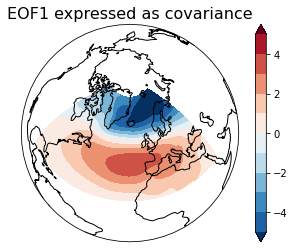

In [78]:
ax = plt.axes(projection=proj)
ax.set_global()
ax.coastlines()
EOFmaps = EOFs_show.sel(mode = 'NAO').plot.contourf('lon','lat',
                                      levels = np.arange(-5,5.1,1.0),
                                      extend = 'both',
                                      subplot_kws=dict(projection = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0,
                                                                                                  central_latitude=90.0),
                                                     )
                                      ,transform = ccrs.PlateCarree(),add_colorbar = True )


plt.title('EOF1 expressed as covariance', fontsize=16)

plt.show()


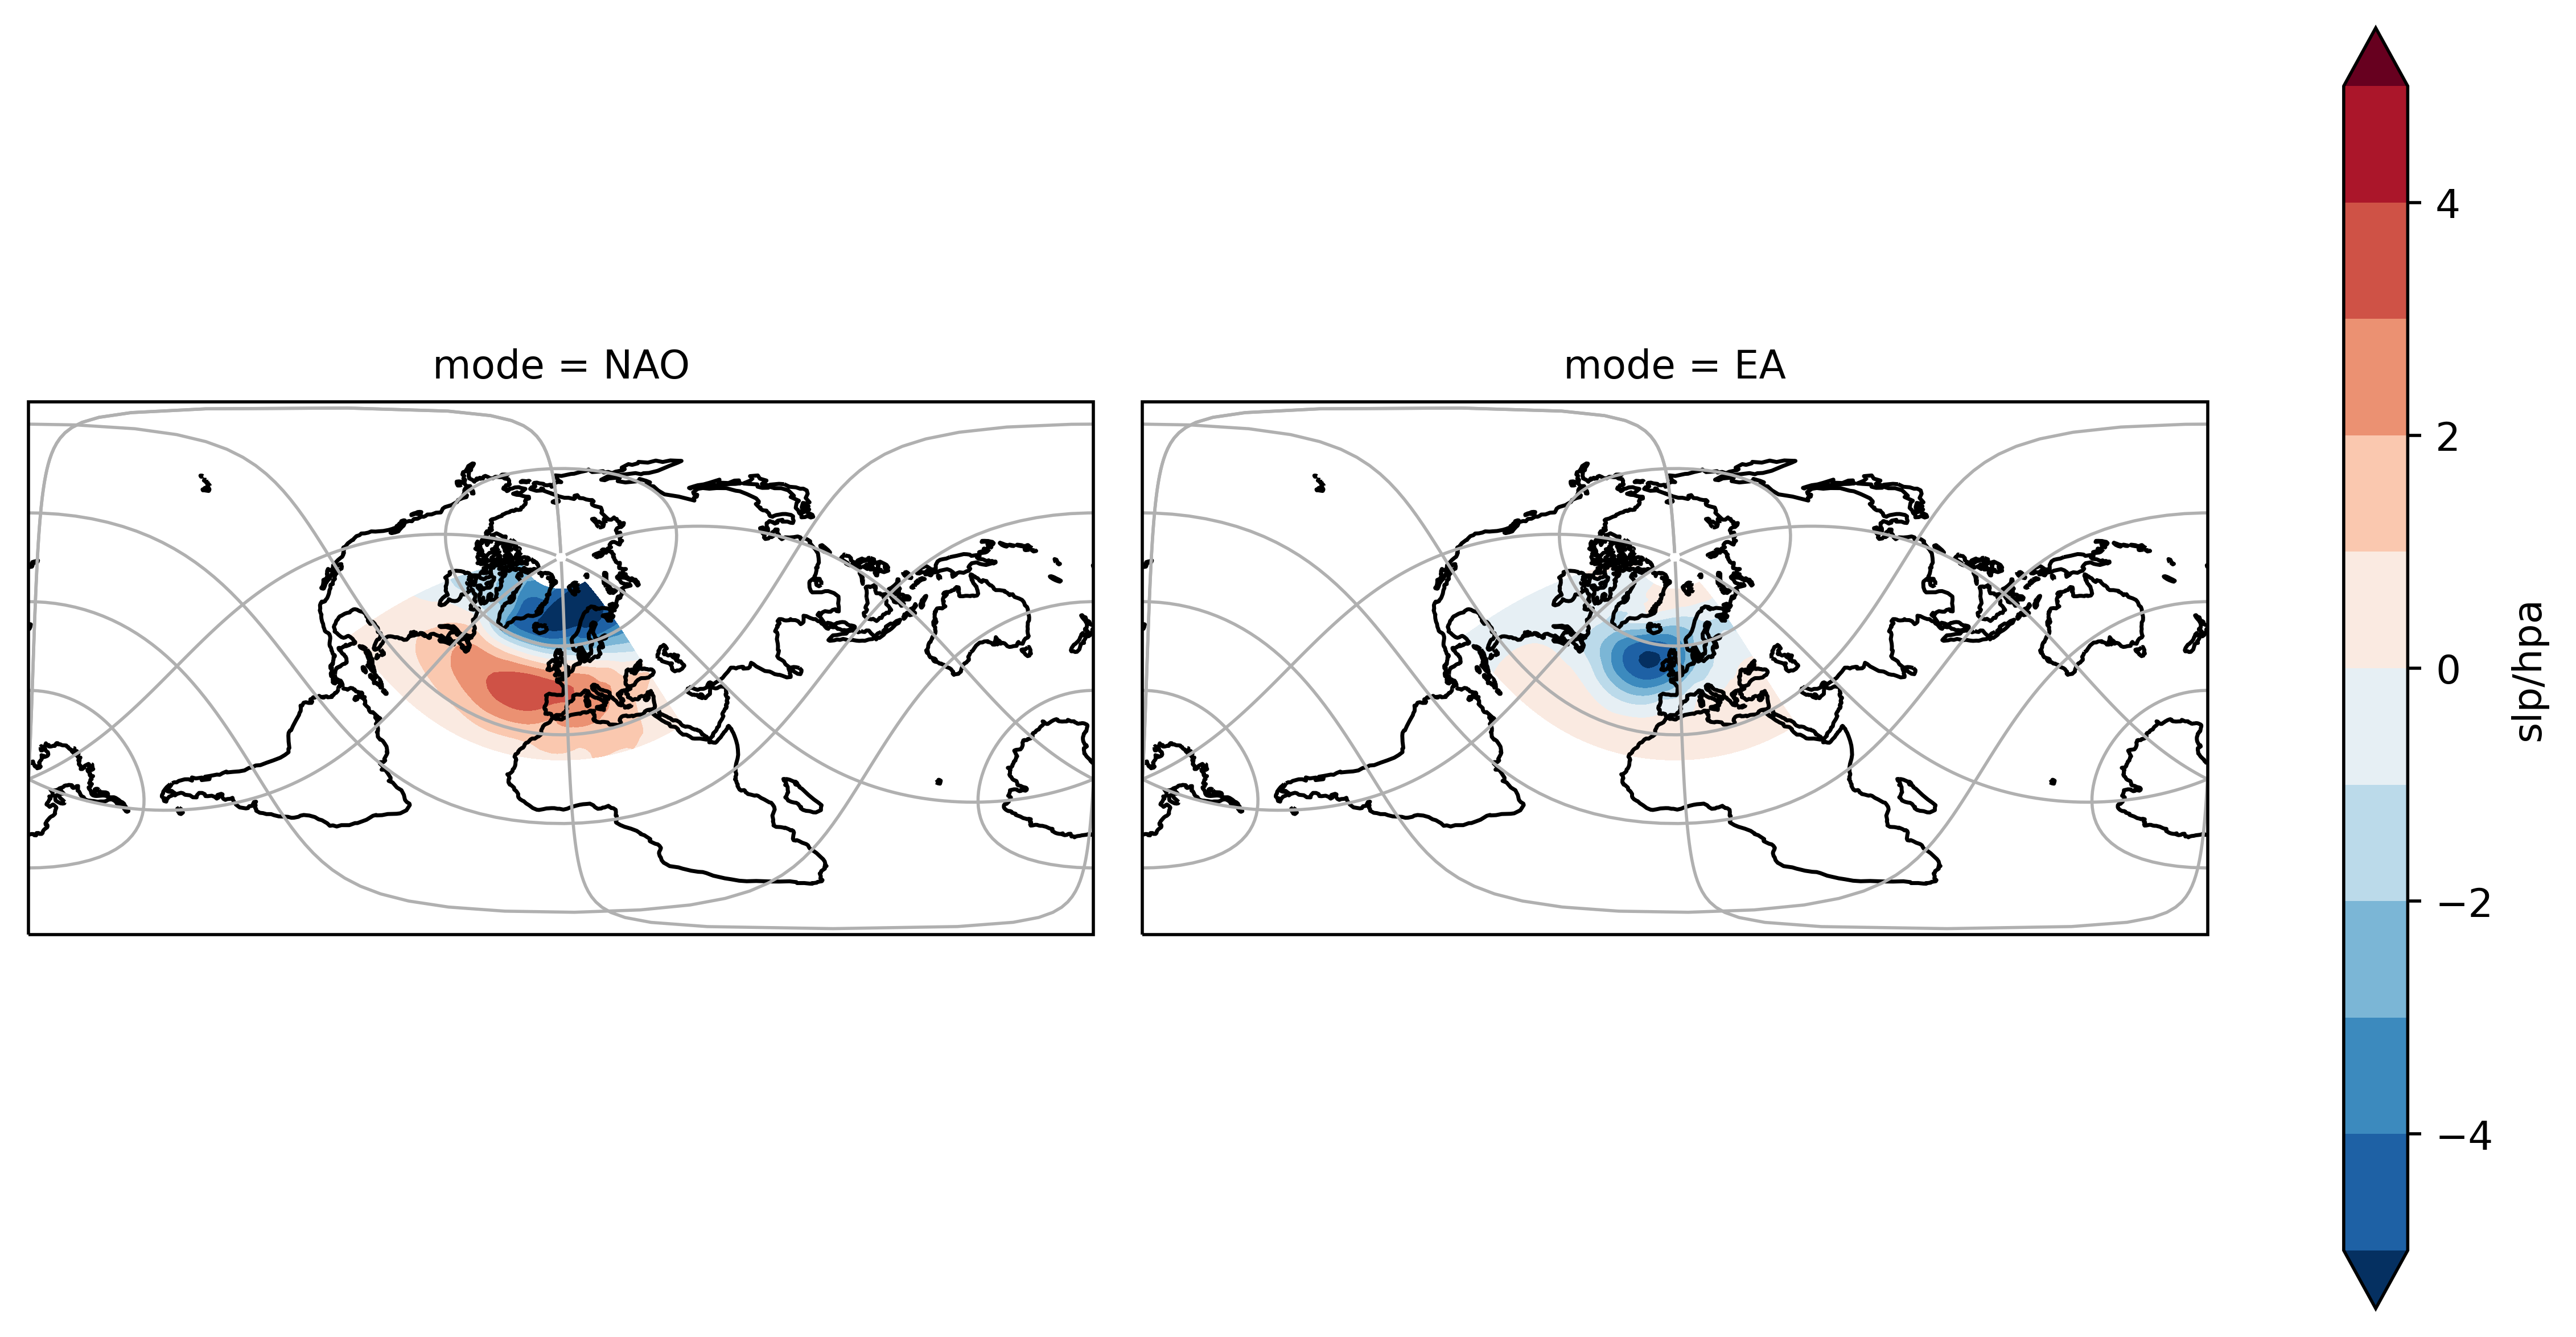

In [69]:
proj = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
EOFmaps = EOFs_show.plot.contourf('lon','lat',col = 'mode',
                                      levels = np.arange(-5,5.1,1.0),
                                      extend = 'both',
                                      subplot_kws=dict(projection =proj)
                                      ,transform = ccrs.PlateCarree(),add_colorbar = True )

for i,ax in enumerate(EOFmaps.axes.reshape(-1)):
    ax.coastlines()
    ax.set_global()
    ax.gridlines()




fig = EOFmaps.fig
fig.set_figheight(5)
fig.set_figwidth(10)
fig.set_dpi(500)
EOFmaps.cbar.set_label("slp/hpa")
# plt.savefig("/work/mh0033/m300883/retreat_2022/spatial_pattern_obs.png",dpi = 500)




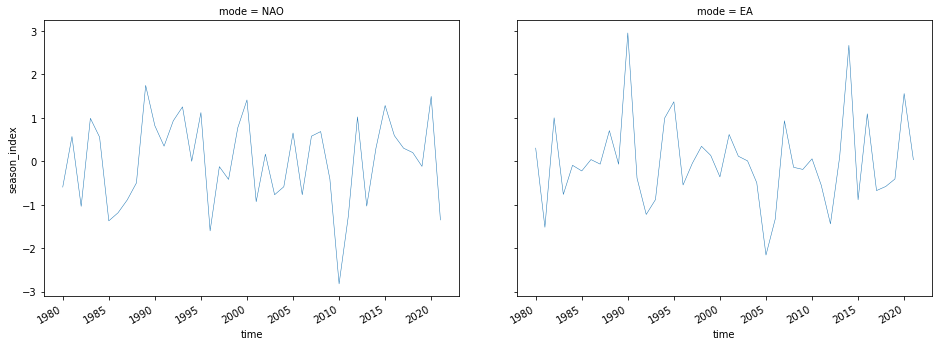

In [54]:
PCmaps =pcs_stded.plot.line(x = 'time',col='mode',linewidth = 0.5)
fig = PCmaps.fig
fig.set_figheight(6)
fig.set_figwidth(13.5)

PCmaps.axes[0,0].set_ylabel('season_index')

plt.show()

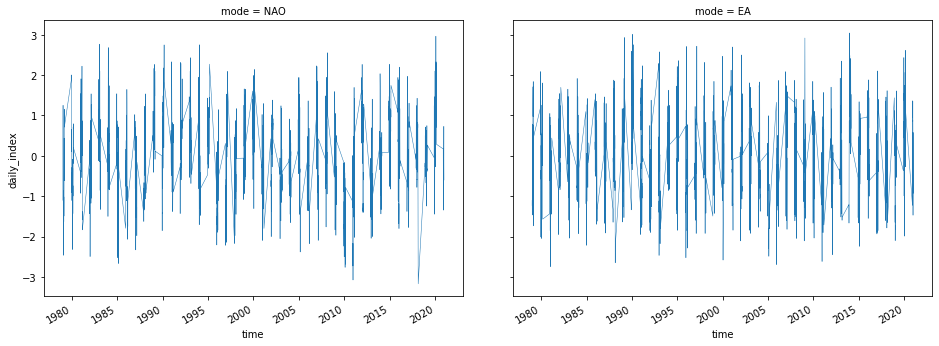

In [100]:
PCmaps =daily_index_stded.plot.line(x = 'time',col='mode',linewidth = 0.5)
fig = PCmaps.fig
fig.set_figheight(6)
fig.set_figwidth(13.5)

PCmaps.axes[0,0].set_ylabel('daily_index')

plt.show()

In [101]:
pcs_stded['time'] = pcs_stded['time'].dt.year

In [104]:
pcs_stded.name = 'pcs'

In [105]:
pc_df = pcs_stded.to_dataframe().reset_index()

In [106]:
pc_df['positive'] = pc_df['pcs'] > 0

In [107]:
pc_df

,time,mode,pcs,positive
0,1980,NAO,-0.594107,False
1,1980,EA,0.302920,True
2,1981,NAO,0.569940,True
3,1981,EA,-1.518806,False
4,1982,NAO,-1.037286,False
...,...,...,...,...
79,2019,EA,-0.408180,False
80,2020,NAO,1.492903,True
81,2020,EA,1.558731,True
82,2021,NAO,-1.350091,False


In [133]:
daily_index_stded.name = 'pseudo_pcs'

In [134]:
index_df = daily_index_stded.to_dataframe().reset_index()

In [135]:
index_df

,time,mode,pseudo_pcs
0,1979-01-01,NAO,-1.098887
1,1979-01-01,EA,-1.227721
2,1979-01-02,NAO,-1.053219
3,1979-01-02,EA,-1.457343
4,1979-01-03,NAO,-0.804169
...,...,...,...
7555,2020-12-29,EA,-0.411041
7556,2020-12-30,NAO,-0.549164
7557,2020-12-30,EA,-0.619909
7558,2020-12-31,NAO,-0.597398


In [136]:
index_df[index_df['mode']=='NAO']['pseudo_pcs']

0      -1.098887
2      -1.053219
4      -0.804169
6      -0.489664
8       0.294196
          ...   
7550   -0.079620
7552   -0.244060
7554   -0.289570
7556   -0.549164
7558   -0.597398
Name: pseudo_pcs, Length: 3780, dtype: float64

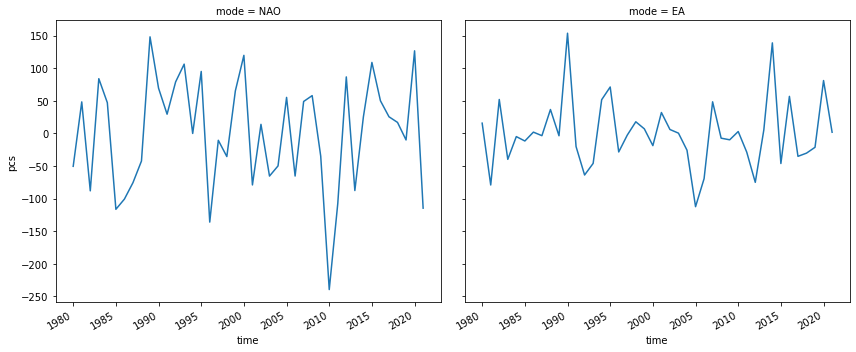

In [55]:
pcs.plot(x='time',col='mode',figsize = (12,5))

In [56]:
pcs_stded['time'] = pcs_stded['time'].dt.year

In [57]:
pcs_stded.name = 'pcs'

In [58]:
df_pcs = pcs_stded.to_dataframe().reset_index()

In [90]:
df_pcs = df_pcs.set_index('time')

In [91]:
df_pcs

,mode,pcs
time,,
1980,NAO,-0.594107
1980,EA,0.302920
1981,NAO,0.569940
1981,EA,-1.518806
1982,NAO,-1.037286
...,...,...
2019,EA,-0.408180
2020,NAO,1.492903
2020,EA,1.558731


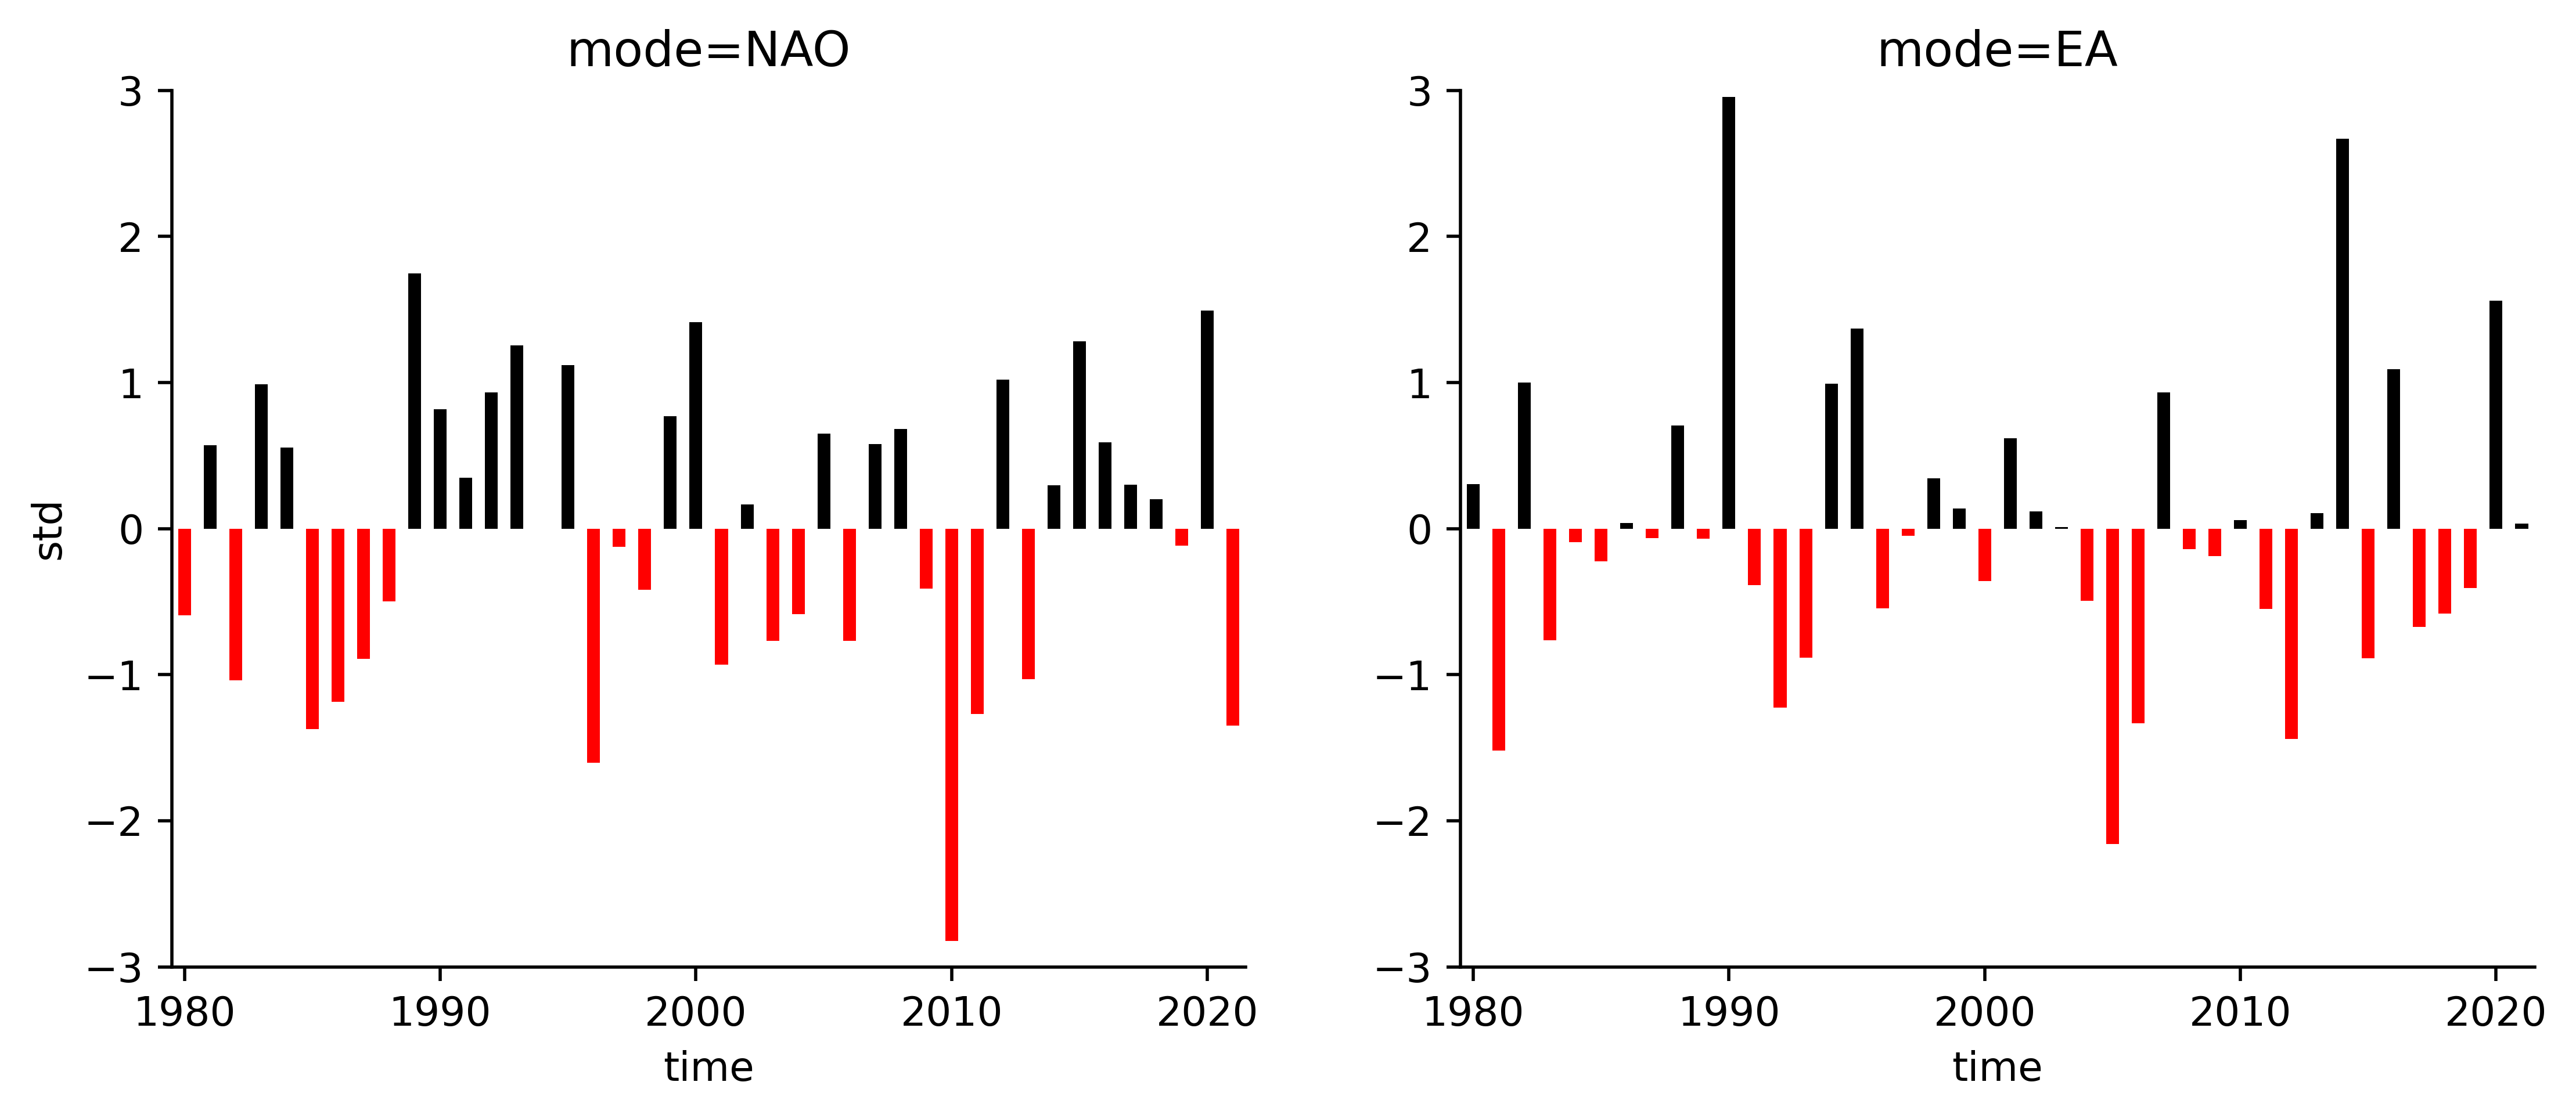

In [107]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig,ax = plt.subplots(1,2,figsize = (10.5,4),dpi = 500)
data = df_pcs[df_pcs['mode']=='NAO']
data['pcs'].plot(kind='bar', rot=0,
                    color=(data['pcs'] > 0).map({True: 'k',
                                                    False: 'r'}),ax = ax[0])
ax[0].xaxis.set_major_locator(MultipleLocator(10))


data = df_pcs[df_pcs['mode']=='EA']
data['pcs'].plot(kind='bar',rot=0,
                    color=(data['pcs'] > 0).map({True: 'k',
                                                    False: 'r'}),ax = ax[1])
ax[1].xaxis.set_major_locator(MultipleLocator(10))

ax[0].set_ylim(-3,3)
ax[1].set_ylim(-3,3)
ax[0].set_title('mode=NAO')
ax[1].set_title('mode=EA')

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(True)
    a.spines['left'].set_visible(True)    
ax[0].set_ylabel('std')
plt.savefig("/work/mh0033/m300883/retreat_2022/index_obs.png",dpi = 500)



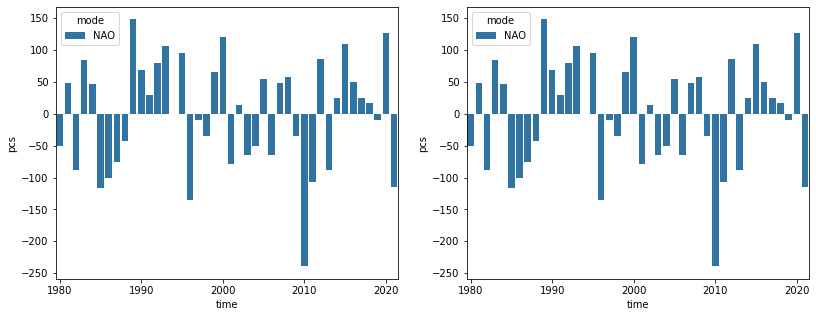

In [160]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig,ax = plt.subplots(1,2,figsize = (13.5,5))
sns.barplot(data =df_pcs[df_pcs['mode']=='NAO'],x='time',y = 'pcs',hue = 'mode',ax = ax[0])
ax[0].xaxis.set_major_locator(MultipleLocator(10))

sns.barplot(data =df_pcs[df_pcs['mode']=='NAO'],x='time',y = 'pcs',hue = 'mode',ax = ax[1])
ax[1].xaxis.set_major_locator(MultipleLocator(10))

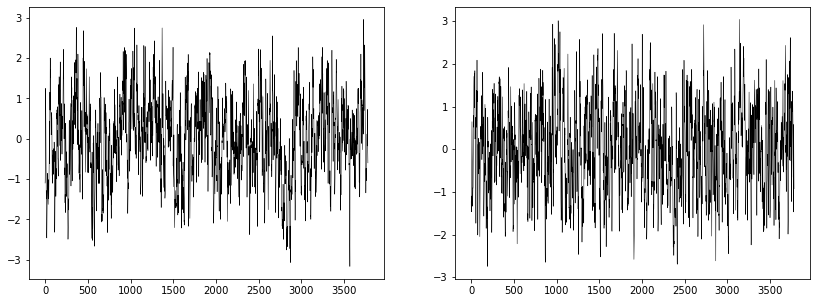

In [56]:
fig,axes = plt.subplots(ncols=2,nrows = 1,figsize = (14,5))

axes[0].plot(daily_index_stded.sel(mode = 'NAO').values,linewidth = 0.5,color = 'k')
axes[1].plot(daily_index_stded.sel(mode = 'EA').values,linewidth = 0.5,color = 'k')

# save

In [42]:
eofs

<xarray.DataArray 'eofs' (mode: 2, lat: 32, lon: 70)>
array([[[-1.1939181e-02, -1.1858105e-02, -1.1744756e-02, ...,
         -2.5835356e-02, -2.5736453e-02, -2.5604069e-02],
        [-1.1386443e-02, -1.1496721e-02, -1.1804952e-02, ...,
         -2.9368360e-02, -2.9169764e-02, -2.8926009e-02],
        [-1.1821556e-02, -1.2153292e-02, -1.2423120e-02, ...,
         -3.2483254e-02, -3.2162525e-02, -3.1791743e-02],
        ...,
        [ 3.1714155e-03,  3.1638972e-03,  3.1571558e-03, ...,
          6.5012686e-03,  5.5413819e-03,  4.7239377e-03],
        [ 3.0847760e-03,  2.9929718e-03,  2.8711602e-03, ...,
          6.3160886e-03,  5.5728098e-03,  4.6135182e-03],
        [ 3.0724793e-03,  2.9123302e-03,  2.7134968e-03, ...,
          5.8970670e-03,  5.4069730e-03,  4.5533874e-03]],

       [[ 5.9670018e-04,  8.2169683e-04,  8.6339691e-04, ...,
          8.1423093e-03,  8.0741616e-03,  8.0001997e-03],
        [ 8.6211599e-04,  6.1531563e-04,  2.8147045e-04, ...,
          7.4583949e-03,  7.3514576e-03,  7.2249714e-03],
        [ 3.2352889e-04,  2.3236912e-04,  8.0821359e-05, ...,
          5.5406797e-03,  5.5023865e-03,  5.4307533e-03],
        ...,
        [-2.5203694e-03, -2.6728008e-03, -2.9481838e-03, ...,
          2.0414887e-03,  1.9269880e-03,  1.9590119e-03],
        [-2.9579648e-03, -2.9849580e-03, -3.0272806e-03, ...,
          2.2340831e-03,  1.8313741e-03,  1.7322666e-03],
        [-3.0109638e-03, -2.9533349e-03, -2.9427267e-03, ...,
          2.7495481e-03,  1.8684804e-03,  1.5419441e-03]]], dtype=float32)
Coordinates:
  * mode     (mode) <U3 'NAO' 'EA'
  * lat      (lat) float64 79.27 77.41 75.54 73.68 ... 27.05 25.18 23.32 21.45
  * lon      (lon) float64 -90.0 -88.12 -86.25 -84.38 ... 33.75 35.62 37.5 39.38
Attributes:
    long_name:  empirical_orthogonal_functions

In [43]:
eof_stded.to_netcdf('/work/mh0033/m300883/task1/Hist_obs/obs/EOF_result/EOFs.nc')

In [44]:
pcs_stded.to_netcdf('/work/mh0033/m300883/task1/Hist_obs/obs/EOF_result/PCs.nc')

In [45]:
daily_index_stded.to_netcdf('/work/mh0033/m300883/task1/Hist_obs/obs/EOF_result/daily_index.nc')

In [39]:
daily_index_stded.name = 'daily_index'

In [40]:
daily_index_stded.to_netcdf('/mnt/lustre01/pf/zmaw/m300883/4 task1/CO2/hist_v.s_obs/daily_index.nc')

In [41]:
daily_index_stded

<xarray.DataArray 'daily_index' (time: 3780, mode: 2)>
array([[-1.09888661, -1.22772121],
       [-1.0532186 , -1.45734346],
       [-0.80416924, -1.09504259],
       ...,
       [-0.28956962, -0.41104111],
       [-0.54916364, -0.61990929],
       [-0.59739816, -0.92686635]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * mode     (mode) <U3 'NAO' 'EA'